In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from torchvision.datasets import ImageFolder

In [2]:
output_dir = '/home/ec2-user/SageMaker/dataset/uncropped_300/'

In [3]:
def get_file_paths(data_dir: str) -> list:
    """Take a directory as input and return a list of paths to all files inside."""
    file_paths = []
    for root_path, _, files in os.walk(data_dir):
        for file in files:
            if file.endswith('png'):
                file_paths.append(os.path.join(root_path, file))
    return file_paths

In [7]:
def load_images(file_paths, dim=(128, 128), verbose=False):
    print(f"Processing {len(file_paths)} image paths...") if verbose else None
    images = []
    
    transform = transforms.Compose([
        transforms.Resize(dim),  # Resize the image
        transforms.ToTensor()  # Convert PIL image to PyTorch tensor
    ])

    for i, file_path in enumerate(file_paths):
        f_path = os.path.join(file_path)
        if "checkpoint" in f_path:
            print(f"[{i+1}] Skipping '{f_path}' (contains 'checkpoint')...") if verbose else None
            continue
        
        # print(f"[{i+1}] Loading '{f_path}' . . .") if verbose else None
        image = Image.open(f_path)
        
        # Convert to RGB if the image has an alpha channel
        if image.mode == 'RGBA':
            image = image.convert('RGB')
        
        image = transform(image)
        images.append(image)
    
    # Resize images to a consistent size
    resized_images = []
    for image in images:
        if image.shape != (3, dim[0], dim[1]):
            resize_transform = transforms.Resize((dim[1], dim[0]))
            image = resize_transform(image)
        resized_images.append(image)
    
    return torch.stack(resized_images)

In [8]:
file_paths = get_file_paths(output_dir)
print(f"Total {len(file_paths)} images in directory.")

Total 13681 images in directory.


In [9]:
# Take a sample of images
percent = 100
N = int(len(file_paths)*percent)
indexes = np.random.randint(low=0, high=len(file_paths), size=N)
sample_files = [path for (i, path) in enumerate(file_paths) if i in indexes]
X = load_images(sample_files, verbose=True, dim=(128, 128))

Processing 13681 image paths...
[13680] Skipping '/home/ec2-user/SageMaker/dataset/uncropped_300/.ipynb_checkpoints/soloAUV 20220908-155425-002-checkpoint.png' (contains 'checkpoint')...
[13681] Skipping '/home/ec2-user/SageMaker/dataset/uncropped_300/.ipynb_checkpoints/soloAUV 20220911-165543-1174-checkpoint.png' (contains 'checkpoint')...


In [10]:
print("X.shape :", X.shape)

seed = 42
X_train, X_test = train_test_split(X, test_size=0.2, random_state=seed)

print("X_train.shape :", X_train.shape)
print("X_test.shape :", X_test.shape)

X.shape : torch.Size([13679, 3, 128, 128])
X_train.shape : torch.Size([10943, 3, 128, 128])
X_test.shape : torch.Size([2736, 3, 128, 128])


In [11]:
def show_images(X, n=10, h=28, w=28, latent_vector=False, title=None, plot_type="grid", figsize=(10, 4)):
    if plot_type == "grid":
        num_rows = int(np.ceil(n / 10))
        fig, axes = plt.subplots(num_rows, 10, figsize=figsize)
        fig.suptitle(title, fontsize=14)
        axes = axes.flatten()
        for i in range(n):
            ax = axes[i]
            if latent_vector:
                img = X[i].reshape(h, w)
            else:
                img = np.transpose(X[i], (1, 2, 0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    elif plot_type == "flat":
        fig, axes = plt.subplots(1, n, figsize=figsize)
        fig.suptitle(title, fontsize=14)
        for i in range(n):
            ax = axes[i]
            if latent_vector:
                img = X[i].reshape(h, w)
            else:
                img = np.transpose(X[i], (1, 2, 0))
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.show()


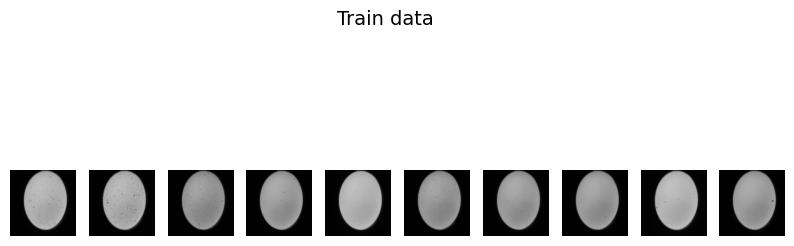

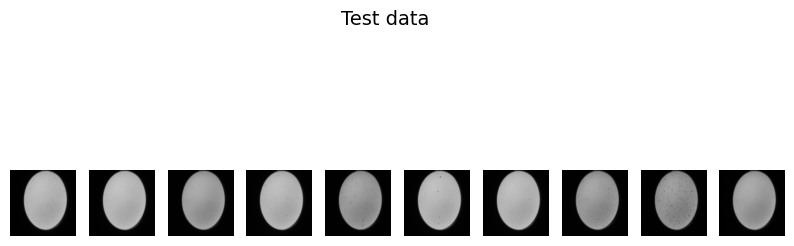

In [12]:
show_images(X_train,  title="Train data", plot_type="flat")
show_images(X_test, title="Test data", plot_type="flat")

# Building Autoencoder

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [14]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Code (latent vector)
        self.code = nn.MaxPool2d(kernel_size=2)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.ConvTranspose2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 3, kernel_size=3, padding=1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        code = self.code(encoded)
        decoded = self.decoder(code)
        return decoded

In [15]:
X_train = X_train.to(device)
X_test = X_test.to(device)

train_dataset = torch.utils.data.TensorDataset(X_train, X_train)
test_dataset = torch.utils.data.TensorDataset(X_test, X_test)

# Define the batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the autoencoder
autoencoder = Autoencoder().to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(autoencoder.parameters())
loss_fn = nn.MSELoss()

# Define the number of epochs
epochs = 50

# Training Loop

In [16]:
for epoch in range(epochs):
    # Training phase
    autoencoder.train()
    train_loss = 0.0
    for batch_data, _ in train_loader:
        # Resize the target tensors to match the output size
        target = torch.nn.functional.interpolate(batch_data, size=(64, 64), mode='bilinear', align_corners=False)
        
        # Move data to CUDA device
        batch_data = batch_data.to(device)
        target = target.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = autoencoder(batch_data)

        # Compute the loss
        loss = loss_fn(output, target)
        train_loss += loss.item()

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    # Evaluation phase
    autoencoder.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch_data, _ in test_loader:
            # Resize the target tensors to match the output size
            target = torch.nn.functional.interpolate(batch_data, size=(64, 64), mode='bilinear', align_corners=False)
            
            # Move data to CUDA device
            batch_data = batch_data.to(device)
            target = target.to(device)
            
            # Forward pass
            output = autoencoder(batch_data)

            # Compute the loss
            loss = loss_fn(output, target)
            test_loss += loss.item()

        test_loss /= len(test_loader)

    # Print the training progress
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.8f} | Test Loss: {test_loss:.8f}")

Epoch 1/50 | Train Loss: 0.01605301 | Test Loss: 0.00164381
Epoch 2/50 | Train Loss: 0.00124967 | Test Loss: 0.00095680
Epoch 3/50 | Train Loss: 0.00083567 | Test Loss: 0.00070199
Epoch 4/50 | Train Loss: 0.00064513 | Test Loss: 0.00060202
Epoch 5/50 | Train Loss: 0.00053935 | Test Loss: 0.00048342
Epoch 6/50 | Train Loss: 0.00048288 | Test Loss: 0.00044403
Epoch 7/50 | Train Loss: 0.00043426 | Test Loss: 0.00041545
Epoch 8/50 | Train Loss: 0.00040090 | Test Loss: 0.00036840
Epoch 9/50 | Train Loss: 0.00038130 | Test Loss: 0.00036151
Epoch 10/50 | Train Loss: 0.00035224 | Test Loss: 0.00038025
Epoch 11/50 | Train Loss: 0.00033660 | Test Loss: 0.00040583
Epoch 12/50 | Train Loss: 0.00033605 | Test Loss: 0.00037569
Epoch 13/50 | Train Loss: 0.00030094 | Test Loss: 0.00040361
Epoch 14/50 | Train Loss: 0.00028938 | Test Loss: 0.00039417
Epoch 15/50 | Train Loss: 0.00028716 | Test Loss: 0.00039986
Epoch 16/50 | Train Loss: 0.00027654 | Test Loss: 0.00027542
Epoch 17/50 | Train Loss: 0.00026

In [17]:
autoencoder.eval()

# Pass the input data through the encoder to get the latent vectors
with torch.no_grad():
    latent_vectors = autoencoder.encoder(X_test)

#Save State Dictonery
torch.save(autoencoder.state_dict(), "autoencoder_weights.pt")
# Save the latent vectors
torch.save(latent_vectors, "Zooplankon_latent_AE.pt")

In [18]:
autoencoder.eval()

# Pass the input data through the encoder to get the latent vectors
with torch.no_grad():
    latent_vectors = autoencoder.encoder(X_test)

# Reshape the latent vectors for visualization
latent_vector = latent_vectors.reshape(len(X_test), -1)

# Print the shapes
print("X_test.shape :", X_test.shape)
print("latent_vector.shape :", latent_vector.shape)

X_test.shape : torch.Size([2736, 3, 128, 128])
latent_vector.shape : torch.Size([2736, 2048])


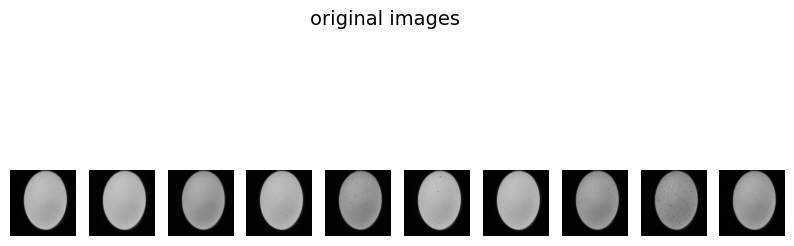

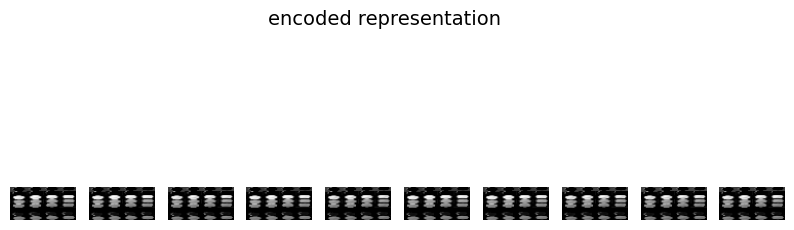

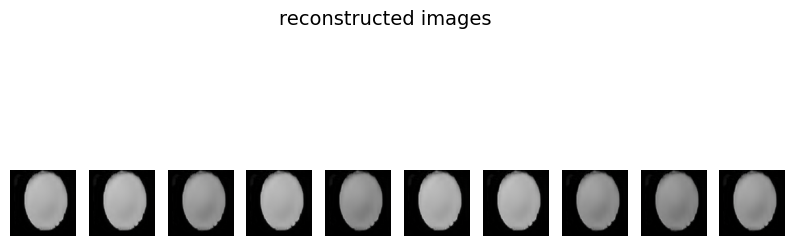

In [19]:
autoencoder.eval()

# Pass the latent vectors through the decoder to reconstruct the images
with torch.no_grad():
    reconstructed_images = autoencoder.decoder(latent_vectors)

reconstructed_images = reconstructed_images.cpu()

# Clip the pixel values to the valid range of [0, 255]
reconstructed_images = torch.clamp(reconstructed_images, 0, 255)

# Convert the reconstructed images to numpy array
reconstructed_images = reconstructed_images.cpu().numpy()

# Show the original images, encoded representation, and reconstructed images
show_images(X_test.cpu(), title="original images", plot_type="flat")
show_images(latent_vector.cpu(), h=32, w=64, latent_vector=True, title="encoded representation", plot_type="flat")
show_images(reconstructed_images, title="reconstructed images", plot_type="flat")

In [20]:
file_paths = get_file_paths("/home/ec2-user/SageMaker/prediction_july4/Dataset")
print(f"Total {len(file_paths)} images in directory.")

Total 502 images in directory.


In [21]:
# Take a sample of images
percent = 100
N = int(len(file_paths)*percent)
indexes = np.random.randint(low=0, high=len(file_paths), size=N)
sample_files = [path for (i, path) in enumerate(file_paths) if i in indexes]
X_test = load_images(sample_files, verbose=True, dim=(128, 128))

Processing 502 image paths...
[501] Skipping '/home/ec2-user/SageMaker/prediction_july4/Dataset/.ipynb_checkpoints/soloAUV 20220909-022428-001-checkpoint.png' (contains 'checkpoint')...
[502] Skipping '/home/ec2-user/SageMaker/prediction_july4/Dataset/.ipynb_checkpoints/soloAUV 20220909-022440-013-checkpoint.png' (contains 'checkpoint')...


In [23]:
X_test = X_test.to(device)

In [24]:
autoencoder.eval()

# Pass the input data through the encoder to get the latent vectors
with torch.no_grad():
    latent_vectors = autoencoder.encoder(X_test)

# Reshape the latent vectors for visualization
latent_vector = latent_vectors.reshape(len(X_test), -1)

# Print the shapes
print("X_test.shape :", X_test.shape)
print("latent_vector.shape :", latent_vector.shape)

X_test.shape : torch.Size([500, 3, 128, 128])
latent_vector.shape : torch.Size([500, 2048])


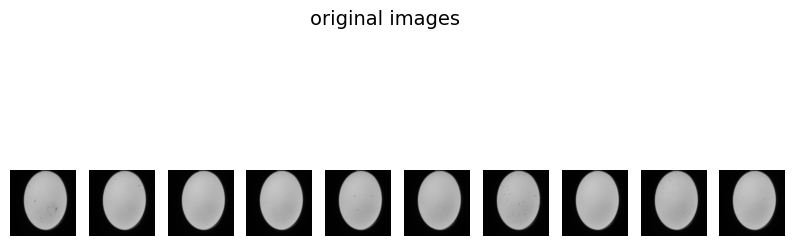

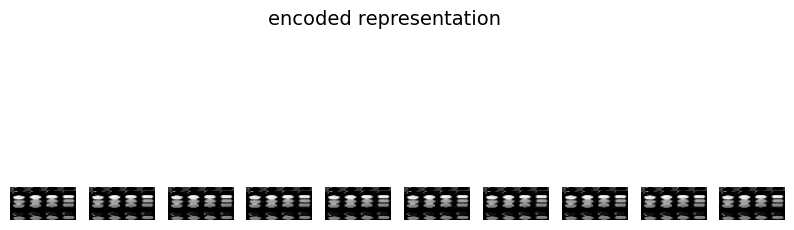

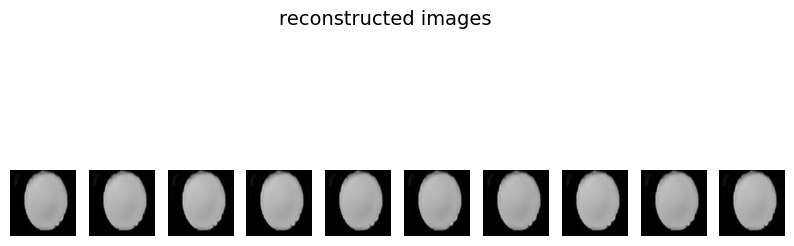

In [25]:
autoencoder.eval()

# Pass the latent vectors through the decoder to reconstruct the images
with torch.no_grad():
    reconstructed_images = autoencoder.decoder(latent_vectors)

reconstructed_images = reconstructed_images.cpu()

# Clip the pixel values to the valid range of [0, 255]
reconstructed_images = torch.clamp(reconstructed_images, 0, 255)

# Convert the reconstructed images to numpy array
reconstructed_images = reconstructed_images.cpu().numpy()

# Show the original images, encoded representation, and reconstructed images
show_images(X_test.cpu(), title="original images", plot_type="flat")
show_images(latent_vector.cpu(), h=32, w=64, latent_vector=True, title="encoded representation", plot_type="flat")
show_images(reconstructed_images, title="reconstructed images", plot_type="flat")

# Clustering the Latent Space

In [26]:
k = 2
random_state = np.random.randint(0, 500)
clusters = KMeans(k, random_state=random_state)
clusters.fit(latent_vector.cpu())
cluster_id = clusters.labels_

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [27]:
print(X_test.shape)

torch.Size([500, 3, 128, 128])


In [28]:
df = pd.DataFrame(X_test.cpu().reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
df["clusterid"] = clusters.labels_
df

,0,1,2,3,4,5,6,7,8,9,...,49143,49144,49145,49146,49147,49148,49149,49150,49151,clusterid
0,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0
1,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,1
2,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,1
3,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,1
4,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0
496,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,1
497,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0
498,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,0.003922,1


In [29]:
clusters = dict()
for cid in df.clusterid.unique():
    clusters[cid] = df[df.clusterid == cid].drop("clusterid", axis="columns").to_numpy()

In [30]:
def show_random_samples(X, n=12, h=400, w=400, latent_vector=False, title="", figsize=(16, 16), plot_type="grid"):
    # Reshape if needed
    if X.ndim == 2 and latent_vector:
        X = X.reshape(X.shape[0], 3, h, w)
    if X.ndim == 2:
        X = X.reshape(X.shape[0], 3, h, w)
    
    # Take random sample
    idxs = np.random.randint(len(X), size=n)
    
    # Create a list to store images from each cluster
    cluster_images = [[] for _ in range(n)]
    
    # Collect images from each cluster
    for i, idx in enumerate(idxs):
        cluster_images[i % n].append(X[idx])
    
    # Calculate optimal figsize for horizontal display
    image_height = cluster_images[0][0].shape[1]
    image_width = cluster_images[0][0].shape[2]
    figsize = (figsize[0], (figsize[0] / n) * (image_height / image_width))
    
    # Plot images horizontally for each cluster
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    for i, images in enumerate(cluster_images):
        combined_image = np.concatenate(images, axis=2)
        ax[i].imshow(combined_image.transpose(1, 2, 0))
        ax[i].axis('off')
        ax[i].set_aspect('auto')
    
    # Show plot
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

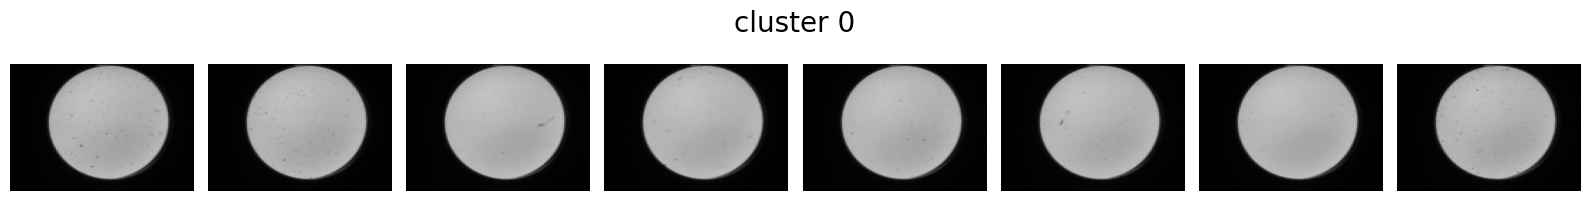

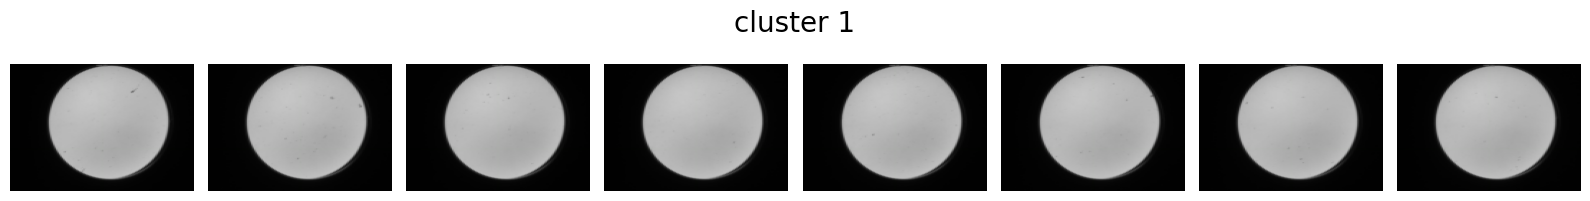

In [31]:
for cid in sorted(clusters.keys()):
    show_random_samples(clusters[cid], h=128, w=128, n=8, title=f"cluster {cid}", plot_type="grid")

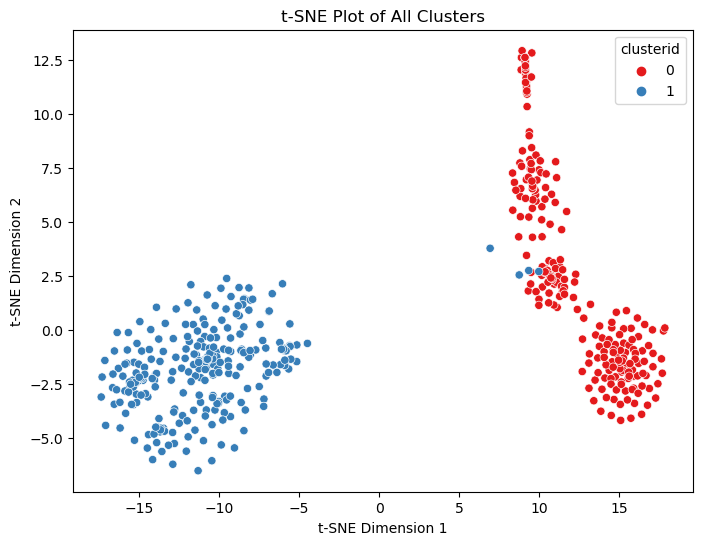

In [32]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have the `clusters` dictionary containing the cluster data

# Concatenate the clusters into a single array
concatenated_clusters = np.concatenate(list(clusters.values()))

# Create a DataFrame for the concatenated clusters
df_concatenated = pd.DataFrame(concatenated_clusters)

# Add a column for cluster labels
df_concatenated['clusterid'] = np.concatenate([np.full(len(cluster), cid) for cid, cluster in clusters.items()])

# Perform t-SNE on the concatenated data
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(df_concatenated.drop('clusterid', axis=1))

# Create a scatter plot of the t-SNE representation with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_representation[:, 0], y=tsne_representation[:, 1], hue=df_concatenated['clusterid'], palette='Set1', legend='full')
plt.title('t-SNE Plot of All Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()


# EM Clustering

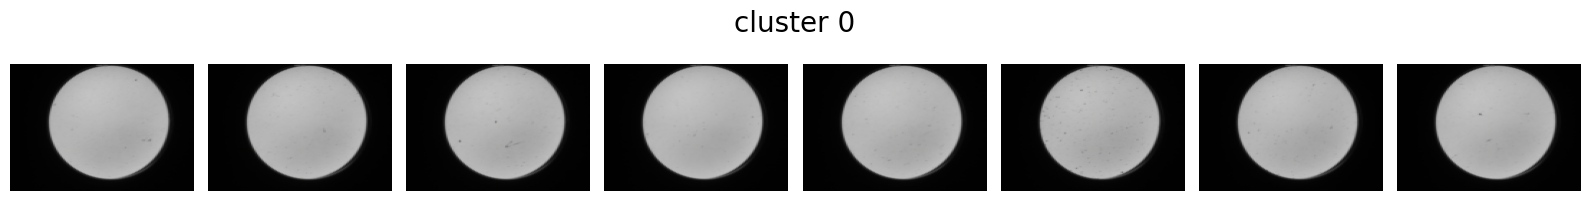

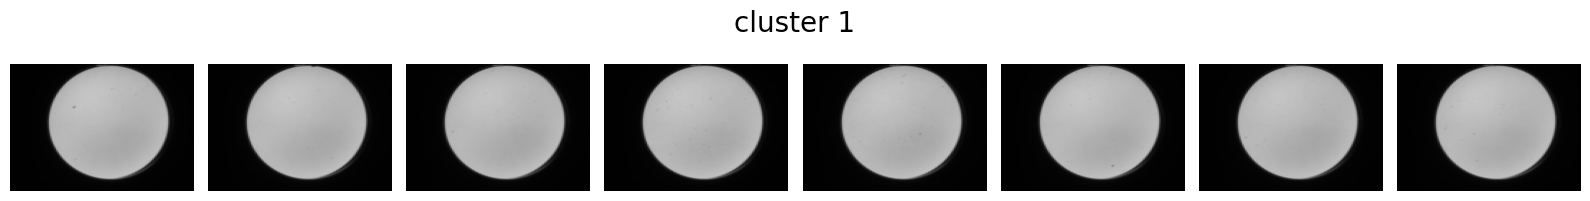

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Define the number of clusters and random state
k = 2
random_state = np.random.randint(0, 500)

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=k, random_state=random_state)
gmm.fit(latent_vector.cpu())
cluster_id = gmm.predict(latent_vector.cpu())

# Create DataFrame with cluster labels
df = pd.DataFrame(X_test.cpu().reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))
df["clusterid"] = cluster_id

# Store clusters in a dictionary
clusters = dict()
for cid in df.clusterid.unique():
    clusters[cid] = df[df.clusterid == cid].drop("clusterid", axis="columns").to_numpy()

# Function to visualize random samples
def show_random_samples(X, n=12, h=400, w=400, latent_vector=False, title="", figsize=(16, 16), plot_type="grid"):
    # Reshape if needed
    if X.ndim == 2 and latent_vector:
        X = X.reshape(X.shape[0], 3, h, w)
    if X.ndim == 2:
        X = X.reshape(X.shape[0], 3, h, w)
    
    # Take random sample
    idxs = np.random.randint(len(X), size=n)
    
    # Create a list to store images from each cluster
    cluster_images = [[] for _ in range(n)]
    
    # Collect images from each cluster
    for i, idx in enumerate(idxs):
        cluster_images[i % n].append(X[idx])
    
    # Calculate optimal figsize for horizontal display
    image_height = cluster_images[0][0].shape[1]
    image_width = cluster_images[0][0].shape[2]
    figsize = (figsize[0], (figsize[0] / n) * (image_height / image_width))
    
    # Plot images horizontally for each cluster
    fig, ax = plt.subplots(nrows=1, ncols=n, figsize=figsize)
    for i, images in enumerate(cluster_images):
        combined_image = np.concatenate(images, axis=2)
        ax[i].imshow(combined_image.transpose(1, 2, 0))
        ax[i].axis('off')
        ax[i].set_aspect('auto')
    
    # Show plot
    plt.suptitle(title, fontsize=20)
    plt.tight_layout()
    plt.show()

# Visualize clusters
for cid in sorted(clusters.keys()):
    show_random_samples(clusters[cid], h=128, w=128, n=8, title=f"cluster {cid}", plot_type="grid")


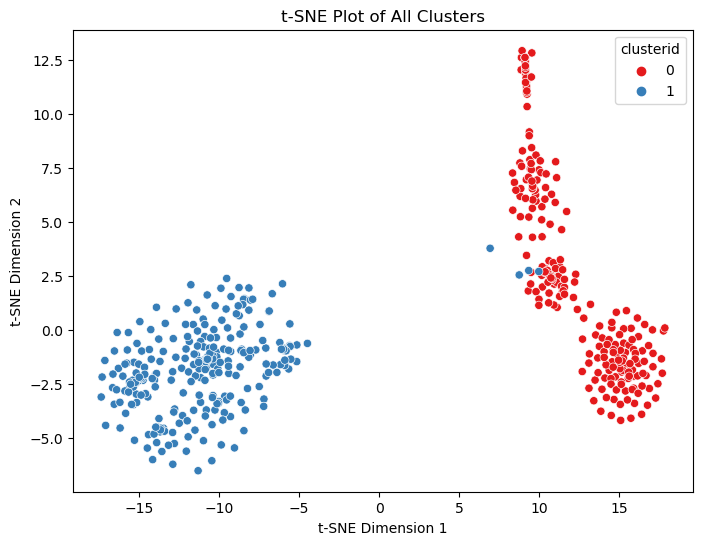

In [35]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Assuming you have the `clusters` dictionary containing the cluster data

# Concatenate the clusters into a single array
concatenated_clusters = np.concatenate(list(clusters.values()))

# Create a DataFrame for the concatenated clusters
df_concatenated = pd.DataFrame(concatenated_clusters)

# Add a column for cluster labels
df_concatenated['clusterid'] = np.concatenate([np.full(len(cluster), cid) for cid, cluster in clusters.items()])

# Perform t-SNE on the concatenated data
tsne = TSNE(n_components=2, random_state=42)
tsne_representation = tsne.fit_transform(df_concatenated.drop('clusterid', axis=1))

# Create a scatter plot of the t-SNE representation with cluster labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_representation[:, 0], y=tsne_representation[:, 1], hue=df_concatenated['clusterid'], palette='Set1', legend='full')
plt.title('t-SNE Plot of All Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()
